# Torch Preprocessing

In [1]:
import matplotlib as plt
%matplotlib inline
import numpy as np 
import pandas as pd 
import torch
import torchtext
from torchtext import data
import spacy
import os

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy
from sklearn.metrics import roc_auc_score

spacy_en = spacy.load('en')

_stopwords = spacy.lang.en.stop_words.STOP_WORDS

os.environ['OMP_NUM_THREADS'] = '4'


SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
# Add padding to avoid having contributions which cannot be passed to the model
def tokenizer(text):
    token = [t.text for t in spacy_en.tokenizer(text)]
    for i in range(1, 3 ):
        token.append('<PAD>')
    return token

# Tokenizing and remove stopwords with spicy
TEXT = data.Field(lower=True,include_lengths=False,tokenize=tokenizer)
#Uncomment line below to remove stopwods
#TEXT = data.Field(lower=True,include_lengths=False,tokenize=tokenizer, stop_words = _stopwords)
LABEL = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                            unk_token=None, dtype = torch.float)

dataFields = {"comment_text": ("comment_text", TEXT), 
              'toxic': ("toxic", LABEL), 
              'severe_toxic': ("severe_toxic", LABEL),
              'threat': ("threat", LABEL), 
              'obscene': ("obscene", LABEL),
              'insult': ("insult", LABEL), 
              'identity_hate': ("identity_hate", LABEL)}

In [3]:
data_dir = '../data/'
data_name = 'train_preprocessed.json'

In [4]:
dataset= data.TabularDataset(path=data_dir+data_name, 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=True)

In [5]:
import random
SEED = 3
train_data, val_data = dataset.split(split_ratio=0.9,random_state = random.seed(SEED))

In [6]:
MAX_VOCAB_SIZE = 20_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

In [7]:
BATCH_SIZE = 256 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, val_data), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.comment_text),
    sort_within_batch = True,
    device = device)

In [8]:
# Save vocab
import pickle
pickle.dump(TEXT, open('../stored_models/cnn_TEXT_vocab', 'wb'))

# Pytorch convolutional model

In [9]:
import torch.nn as nn
from torch.functional import F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)


In [28]:
INPUT_DIM = len(TEXT.vocab) # 20002
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = 6
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # 1

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES ,OUTPUT_DIM, DROPOUT, PAD_IDX)

# Copy word embedding form torchtext vocab
model.embedding.weight.data.copy_(TEXT.vocab.vectors)



tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.1898, -0.1176, -0.3154,  ...,  0.0558, -0.7294, -0.4067],
        [-0.3683, -0.5918,  0.2659,  ..., -0.4553,  0.3215,  0.0155],
        [-0.1904,  0.2684, -0.1786,  ..., -0.2058, -0.2766, -0.5358]])

In [11]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.1898, -0.1176, -0.3154,  ...,  0.0558, -0.7294, -0.4067],
        [-0.3683, -0.5918,  0.2659,  ..., -0.4553,  0.3215,  0.0155],
        [-0.1904,  0.2684, -0.1786,  ..., -0.2058, -0.2766, -0.5358]])


In [12]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')
counter = 0
for i in train_iterator:
    aux=i
    counter+=1
    if counter == 1: break

from torchsummaryX import summary
print(aux.comment_text.size())
summary(model, aux.comment_text )



The model has 2,092,306 trainable parameters
torch.Size([15, 256])
                      Kernel Shape       Output Shape   Params Mult-Adds
Layer                                                                   
0_embedding           [100, 20002]     [256, 15, 100]  2.0002M   2.0002M
1_convs.Conv2d_0  [1, 100, 2, 100]  [256, 100, 14, 1]    20.1k    280.0k
2_convs.Conv2d_1  [1, 100, 3, 100]  [256, 100, 13, 1]    30.1k    390.0k
3_convs.Conv2d_2  [1, 100, 4, 100]  [256, 100, 12, 1]    40.1k    480.0k
4_dropout                        -         [256, 300]        -         -
5_fc                      [300, 6]           [256, 6]   1.806k      1.8k
---------------------------------------------------------------------------
                         Totals
Total params          2.092306M
Trainable params      2.092306M
Non-trainable params        0.0
Mult-Adds                3.152M


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_embedding,"[100, 20002]","[256, 15, 100]",2000200.0,2000200.0
1_convs.Conv2d_0,"[1, 100, 2, 100]","[256, 100, 14, 1]",20100.0,280000.0
2_convs.Conv2d_1,"[1, 100, 3, 100]","[256, 100, 13, 1]",30100.0,390000.0
3_convs.Conv2d_2,"[1, 100, 4, 100]","[256, 100, 12, 1]",40100.0,480000.0
4_dropout,-,"[256, 300]",NaN,NaN
5_fc,"[300, 6]","[256, 6]",1806.0,1800.0


In [13]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

## Define training and evaluation functions

In [14]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    yFields = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
    epoch_loss = 0; epoch_acc = 0
    preds_list=[]; labels_list= []; epoch_loss_hist = []
    
    j = len(iterator)//2 
    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        text = batch.comment_text
        predictions = model(text)
        
        batch_labels=torch.stack([getattr(batch, y) for y in yFields]) #transpose?
        batch_labels = torch.transpose(batch_labels,0,1)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()
        preds_list+=[torch.sigmoid(predictions).detach().numpy()]
        labels_list+=[batch_labels.numpy()]
        epoch_loss += loss.item()
        
        if i%j ==0:
            epoch_loss_hist.append([loss.item(),
            evaluate(model, valid_iterator, criterion)[0]])
            model.train()
        
    return (epoch_loss / len(iterator) , epoch_loss_hist, 
           roc_auc_score(np.vstack(labels_list), np.vstack(preds_list)))

In [15]:
def evaluate(model, iterator, criterion):
    model.eval()
    
    yFields = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
    epoch_loss = 0; epoch_acc = 0
    preds_list=[]; labels_list= []; epoch_acc=[]

    with torch.no_grad():
        i=0
        for batch in iterator:
            i+=1
            text = batch.comment_text
            predictions = model(text)#.squeeze(1)
            batch_labels = torch.stack([getattr(batch, y) for y in yFields]) #transpose?
            batch_labels = torch.transpose(batch_labels,0,1)
            loss = criterion(predictions, batch_labels)
            epoch_loss += loss.item()
            preds_list+=[torch.sigmoid(predictions).detach().numpy()]
            labels_list+=[batch_labels.numpy()]
                  
    return (epoch_loss / len(iterator),
           roc_auc_score(np.vstack(labels_list), np.vstack(preds_list)) ,
           np.vstack(preds_list), np.vstack(labels_list))

In [16]:
def print_metrics(pred, labels, thre= 0.5):
    toxic_labels = ['toxic','severe_toxic',
               'obscene','threat','insult',
               'identity_hate']
    
    roc_auc_scores= []
    recall_scores=[]
    precision_scores=[]
    accuracy_scores=[]
    f1_scores=[]

     
    for i,j in enumerate(toxic_labels):
        roc_auc_scores.append(roc_auc_score(labels[:,i], pred[:,i]))
        recall_scores.append(recall_score(labels[:,i], pred[:,i]>=thre))
        accuracy_scores.append(accuracy_score(labels[:,i], pred[:,i]>=thre))
        precision_scores.append(precision_score(labels[:,i], pred[:,i]>=thre))
        f1_scores.append(f1_score(labels[:,i], pred[:,i]>=thre))
    return pd.DataFrame(
    {'Label': toxic_labels,
     'accuracy': accuracy_scores,
     'recall': recall_scores,
     'precision': precision_scores,
     'f1': f1_scores,
     'roc_auc': roc_auc_scores})

## Training on dataset

In [17]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
model.embedding.weight.requires_grad = True

N_EPOCHS = 3
best_valid_loss = float('inf')
loss_hist= []; acc_hist= []
#UNFREEZE = 4
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, _loss_hist, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, _preds  , _labels  = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    
    loss_hist+= _loss_hist
    acc_hist+= [[valid_acc, train_acc]]
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '../stored_models/cnn-model.pt')
        

#    if (epoch) > UNFREEZE:
#        #unfreeze embeddings
#        model.embedding.weight.requires_grad = True 
    
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 3m 36s
	Train Loss: 0.081 | Train Acc: 89.22%
	 Val. Loss: 0.050 |  Val. Acc: 97.04%
Epoch: 02 | Epoch Time: 3m 29s
	Train Loss: 0.053 | Train Acc: 96.98%
	 Val. Loss: 0.047 |  Val. Acc: 97.78%
Epoch: 03 | Epoch Time: 3m 23s
	Train Loss: 0.048 | Train Acc: 97.87%
	 Val. Loss: 0.045 |  Val. Acc: 98.06%


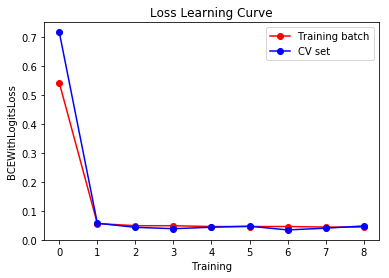

In [36]:
import matplotlib.pyplot as plt
title = 'Loss Learning Curve'
plt.title(title)
plt.plot([i[1] for i in loss_hist], 'o-', color="r",label= "Training batch")
plt.plot([i[0] for i in loss_hist],  'o-', color="b", label="CV set")
plt.legend(loc="best")
plt.xlabel("Training")
plt.ylabel("BCEWithLogitsLoss")
plt.savefig('../plots_tables/'+'lstm'+title.replace(' ', '_')+'.png')

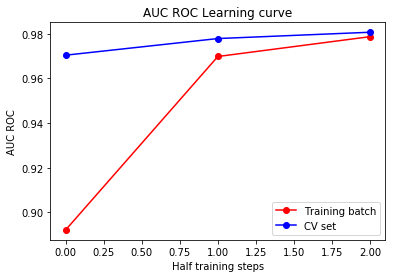

In [37]:
title = 'AUC ROC Learning curve'
plt.title(title)
plt.plot([i[1] for i in acc_hist], 'o-', color="r",label= "Training batch")
plt.plot([i[0] for i in acc_hist],  'o-', color="b", label="CV set")
plt.legend(loc="best")
plt.xlabel("Half training steps")
plt.ylabel("AUC ROC")
plt.savefig('../plots_tables/'+'lstm'+title.replace(' ', '_')+'.png')

In [27]:
print_metrics(_preds , _labels,0.5)

,Label,accuracy,recall,precision,f1,roc_auc
0,toxic,0.964091,0.725296,0.875895,0.793514,0.974601
1,severe_toxic,0.991540,0.145985,0.526316,0.228571,0.988882
2,obscene,0.982578,0.777778,0.865385,0.819246,0.984397
3,threat,0.997431,0.024390,0.500000,0.046512,0.973423
4,insult,0.974995,0.632992,0.815486,0.712743,0.984595
5,identity_hate,0.992918,0.242188,0.659574,0.354286,0.977930


# Testing 

In [31]:
data_test =  'test_preprocessed.json'

In [32]:
dataFields = {"comment_text": ("comment_text", TEXT)}



test_data = data.TabularDataset(path=data_dir+data_test, 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=False)

In [33]:
test_iterator = torchtext.data.Iterator(test_data, batch_size=64, device=device, 
                                     sort=False, sort_within_batch=False, 
                                     repeat=False,shuffle=False)

In [34]:
myPreds=[]
with torch.no_grad():
    model.eval()
    for batch in test_iterator:

        torch.cuda.empty_cache()
    
        text = batch.comment_text    
        predictions = model(text).squeeze(1)         
        myPreds+=[torch.sigmoid(predictions).detach().numpy()]
    
        torch.cuda.empty_cache()
myPreds = np.vstack(myPreds)

In [35]:
testDF= pd.read_csv(data_dir+'test.csv')
for i, col in enumerate(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]):
    testDF[col] = myPreds[:, i]


testDF.drop("comment_text", axis=1).to_csv("../results_for_kaggle/cnn_kaggle_3epochs.csv", index=False)